In [139]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from GeneralModel import GeneralModel

In [140]:
df1 = pd.read_csv("./Source_code/traceability/practice_1/TECO_amb.csv", usecols=["Scaler1"])
df2 = pd.read_csv("./Source_code/traceability/practice_1/TECO_eco2.csv", usecols=["Scaler1"])
xi1 = df1.values.reshape(df1.shape[0])
xi2 = df2.values.reshape(df2.shape[0])


In [141]:
df3 = pd.read_csv("./Source_code/traceability/practice_1/matrix_A_K.csv", usecols=["A_1", "A_2", "A_3", "A_4", "A_5", "A_6", "A_7", "A_8"])
tmp = df3.values
matrix_A = -tmp

In [142]:
df4 = pd.read_csv("./Source_code/traceability/practice_1/matrix_A_K.csv", usecols=["K_1", "K_2", "K_3", "K_4", "K_5", "K_6", "K_7", "K_8"])
matrix_K = df4.values

In [143]:
df5 = pd.read_csv("./Source_code/traceability/practice_1/matrix_A_K.csv", usecols=["B"])
B = df5.values

In [144]:
init_pool_sizes = np.array([189.1422677,189.1422677,5129.556399,115.5794802,
                            742.8968061,102.9411519,5561.097498,8727.271319]).reshape([8])
# init_pool_sizes = np.array([0,0,0,0,0,0,0,0]).reshape([8])

In [145]:
df6 = pd.read_csv("./Source_code/traceability/practice_1/input/Forcing_SPRUCE_400ppm_Daily.csv", usecols=["GPP"])
GPP1 = df6.values.reshape(2922)
df7 = pd.read_csv("./Source_code/traceability/practice_1/input/Forcing_SPRUCE_900ppm_Daily.csv", usecols=["GPP"])
GPP2 = df7.values.reshape(2922)
date = pd.read_csv("./Source_code/traceability/practice_1/input/Forcing_SPRUCE_900ppm_Daily.csv", usecols=["Date"])

In [146]:
times = np.arange(0, 2922, 1)

In [147]:
mod1 = GeneralModel(times, B, matrix_A, matrix_K, init_pool_sizes, GPP1, xi1)
res1 = mod1.get_x_df()
#mod1.write_output("./output.csv")
res1["Date"] = date["Date"]
res1['Date']=pd.to_datetime(res1['Date'],format="%Y-%m-%d")
res1.set_index("Date", inplace=True)
#res1_yearly = res1.resample('AS').sum().to_period('A')
res1_yearly = res1.resample('A').mean()
res1_yearly_values = res1_yearly.values
#res1_yearly_values / 365
tmp1 = pd.DataFrame(res1_yearly_values)
tmp1.columns = res1_yearly.columns
tmp1.index = res1_yearly.index

In [148]:
mod2 = GeneralModel(times, B, matrix_A, matrix_K, init_pool_sizes, GPP2, xi2)
res2 = mod2.get_x_df()
res2["Date"] = date["Date"]
res2['Date']=pd.to_datetime(res2['Date'],format="%Y-%m-%d")
res2.set_index("Date", inplace=True)
#res2_yearly = res2.resample('AS').sum().to_period('A')
res2_yearly = res2.resample('A').mean()
res2_yearly_values = res2_yearly.values
#res2_yearly_values / 365
tmp2 = pd.DataFrame(res2_yearly_values)
tmp2.columns = res2_yearly.columns
tmp2.index = res2_yearly.index

In [150]:
ref_amb = np.zeros([8,8])
pools = ["Foliage", "Root", "Wood", "Fine_litter", "CWD", "Fast_SOC", "Slow_SOC", "Passive_SOC"]
df_tmp1 = pd.read_csv("./Source_code/traceability/practice_1/traceability_yr.csv")
df_tmp1 = df_tmp[(df_tmp1.Model == "TECO")]
df_tmp1 = df_tmp1[df_tmp1.Treatment == "amb"]
for i in range(len(pools)):
    df_tmp2 = df_tmp1[df_tmp1.Pool == pools[i]]
    ref_amb[:, i] = df_tmp2.X.values
    

In [151]:
ref_eco2 = np.zeros([8,8])
pools = ["Foliage", "Root", "Wood", "Fine_litter", "CWD", "Fast_SOC", "Slow_SOC", "Passive_SOC"]
df_tmp1 = pd.read_csv("./Source_code/traceability/practice_1/traceability_yr.csv")
df_tmp1 = df_tmp[(df_tmp1.Model == "TECO")]
df_tmp1 = df_tmp1[df_tmp1.Treatment == "eco2"]
for i in range(len(pools)):
    df_tmp2 = df_tmp1[df_tmp1.Pool == pools[i]]
    ref_eco2[:, i] = df_tmp2.X.values

In [152]:
pools = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8"]

mod_amb = pd.DataFrame(tmp1, columns=pools).values
mod_eco2 = pd.DataFrame(tmp2, columns=pools).values

In [153]:
bias_amb = np.abs(np.mean(mod_amb, axis = 0) - np.mean(ref_amb, axis = 0))
aver_ref_amb = np.mean(ref_amb, axis = 0)
aver_mod_amb = np.mean(mod_amb, axis = 0)
aver_ref_amb_mat = np.zeros([8,8])
aver_mod_amb_mat = np.zeros([8,8])
for i in range(0,8):
    aver_ref_amb_mat[i] = aver_ref_amb
    aver_mod_amb_mat[i] = aver_mod_amb
crms_amb = np.sqrt((ref_amb - aver_ref_amb_mat) * (ref_amb - aver_ref_amb_mat)/8)

In [154]:
crms_amb = np.sum(crms_amb, axis = 0)


In [155]:
sigma_bias = bias_amb/crms_amb
s_bias_amb = np.sum(np.exp(-sigma_bias))/8

In [156]:
rmse_amb = np.sqrt((mod_amb - ref_amb) * (mod_amb - ref_amb)/8)
crmse_amb = np.sqrt((((mod_amb - aver_mod_amb_mat) - (ref_amb - aver_ref_amb_mat)) * ((mod_amb - aver_mod_amb_mat) - (ref_amb - aver_ref_amb_mat)))/8)

In [157]:
crmse_amb = np.sum(crmse_amb, axis = 0)

In [158]:
sigma_rmse_amb = crmse_amb/crms_amb

In [159]:
s_rmse_amb = np.sum(np.exp(-sigma_rmse_amb))/8

In [169]:
s_total_amb = (s_bias_amb + 2 * s_rmse_amb) / 3

In [160]:
bias_eco2 = np.abs(np.mean(mod_eco2, axis = 0) - np.mean(ref_eco2, axis = 0))
aver_ref_eco2 = np.mean(ref_eco2, axis = 0)
aver_mod_eco2 = np.mean(mod_eco2, axis = 0)
aver_ref_eco2_mat = np.zeros([8,8])
aver_mod_eco2_mat = np.zeros([8,8])
for i in range(0,8):
    aver_ref_eco2_mat[i] = aver_ref_eco2
    aver_mod_eco2_mat[i] = aver_mod_eco2
crms_eco2 = np.sqrt((ref_eco2 - aver_ref_eco2_mat) * (ref_eco2 - aver_ref_eco2_mat)/8)

In [161]:
crms_eco2 = np.sum(crms_eco2, axis = 0)

In [162]:
sigma_bias = bias_eco2/crms_eco2
s_bias_eco2 = np.sum(np.exp(-sigma_bias))/8

In [163]:
rmse_eco2 = np.sqrt((mod_eco2 - ref_eco2) * (mod_eco2 - ref_eco2)/8)
crmse_eco2 = np.sqrt((((mod_eco2 - aver_mod_eco2_mat) - (ref_eco2 - aver_ref_eco2_mat)) * ((mod_eco2 - aver_mod_eco2_mat) - (ref_eco2 - aver_ref_eco2_mat)))/8)

In [164]:
crmse_eco2 = np.sum(crmse_eco2, axis = 0)

In [165]:
sigma_rmse_eco2 = crmse_eco2/crms_eco2

In [166]:
s_rmse_eco2 = np.sum(np.exp(-sigma_rmse_eco2))/8

In [167]:
s_total_eco2 = (s_bias_eco2 + 2 * s_rmse_eco2) / 3

In [170]:
s_total_amb

0.6609518623115775

In [171]:
s_total_eco2

0.736497169696256

Text(0, 0.5, 'Score (0~1)')

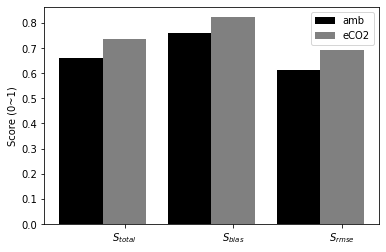

In [176]:
# Plot the scores
name_list = ["$S_{total}$", "$S_{bias}$", "$S_{rmse}$"]
num_list = [s_total_amb, s_bias_amb, s_rmse_amb]
num_list1 = [s_total_eco2, s_bias_eco2, s_rmse_eco2]
x =list(range(len(num_list)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, num_list, width=width, label='amb',fc = 'black')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width=width, label='eCO2',tick_label = name_list,fc = 'gray')
plt.legend()
plt.ylabel("Score (0~1)")